In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from efn_util import setup_IO
from families import family_from_str
from MLE_util import load_dirichlet_MLE_model, dirichlet_MLE
import os;
import seaborn as sns
palette = sns.color_palette("Set1", n_colors=8, desat=.6);
sns.set_palette(palette);


basedir = '/Users/sbittner/Documents/efn/';

D = 10;
K = 1;
M = 1000;
exp_fam = 'dirichlet';
fam_class = family_from_str(exp_fam);
family = fam_class(D);
TIF_flow_type = 'PlanarFlowLayer';
flow_dict = {'latent_dynamics':None, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':D};

num_rs = 10;
rs_list = range(num_rs);

num_ds = 10;
ds_list = range(num_ds);
dir_str = 'bias_var_tradeoff'

dirichlet_MLE_model = load_dirichlet_MLE_model(D);


In [2]:
MLE_fname = basedir + 'results/' + dir_str + '/%s_D=%d_bvt.npz' % (exp_fam, D);

if (os.path.isfile(MLE_fname)):
    npzfile = np.load(fname);
    alpha_targs = npzfile['alpha_targs'];
    VI_alphas = npzfile['VI_alphas'];
else:
    # do MLE for all VI dists
    alpha_targs = np.zeros((num_ds, D));
    VI_alphas = np.zeros((num_ds, num_rs, D));
    num_iters = 2000;
    for i in range(0,num_ds):
        ds = ds_list[i];
        for j in range(num_rs):
            rs = rs_list[j];
            dist_info = {'dist_seed':ds};
            savedir = setup_IO(family, 'NF1', dir_str, '', K, M, flow_dict, {}, False, False, rs, dist_info);
            resdir = basedir + savedir;
            fname = resdir + 'results.npz';
            npzfile = np.load(fname);
            _X = npzfile['X'][0,:,:,0];
            print(_X.shape);
            params = npzfile['params'][()];
            alpha = params['alpha'];
            if (j==0):
                alpha_targs[i,:] = alpha;
            print('alpha', alpha);
            alpha_hat = dirichlet_MLE(dirichlet_MLE_model, _X, num_iters);
            print('alpha hat', alpha_hat);
            VI_alphas[i,j,:] = alpha_hat;
            
    np.savez(MLE_fname, alpha_targs=alpha_targs, VI_alphas=VI_alphas);
    
    # do MLE for the EFN dists
    K= 100;
    M = 1000;
    param_net_hps = {'L':4};
    param_net_input_type = 'eta';
    stochastic_eta = True;
    give_hint = False;

    EFN_alphas = np.zeros((num_ds, num_rs, D));
    # iterate over random seeds
    for rs in range(num_rs):
        savedir = setup_IO(family, 'EFN', dir_str, param_net_input_type, K, M, flow_dict,\
                       param_net_hps, stochastic_eta, give_hint, rs);
        print('loading model %s ...' % savedir);
        resdir = basedir + savedir;
        fname = resdir + 'results.npz';
        npzfile = np.load(fname);

        sess = tf.Session();
        new_saver = tf.train.import_meta_graph(resdir + 'model.meta');
        new_saver.restore(sess, tf.train.latest_checkpoint(resdir));
        print('done.');
        Z0 = tf.get_collection('Z0')[0];
        X = tf.get_collection('X')[0];
        eta = tf.get_collection('eta')[0];
        param_net_input = tf.get_collection('param_net_input')[0];
        log_p_zs = tf.get_collection('log_p_zs')[0];

        for ds in range(num_ds):
            alpha = alpha_targs[ds];
            params = {'alpha':alpha};
            _eta, _param_net_input = family.mu_to_eta(params);

            N = 10000;
            z0 = np.random.normal(0,1,[K,N,D-1,1]);
            _eta = np.concatenate((np.expand_dims(_eta, 0), np.zeros((K-1, D))), 0);
            _param_net_input = np.concatenate((np.expand_dims(_param_net_input, 0), np.zeros((K-1, D))), 0);
            _X = sess.run(X, {Z0:z0, eta:_eta, param_net_input:_param_net_input});
            _X = _X[0,:,:,0];

            alpha_hat = dirichlet_MLE(dirichlet_MLE_model, _X, num_iters);
            print('targ', alpha, 'EFN', alpha_hat);
            EFN_alphas[ds, rs, :] = alpha_hat;

    np.savez(MLE_fname, alpha_targs=alpha_targs, VI_alphas=VI_alphas, EFN_alphas=EFN_alphas);

(10000, 10)
alpha [2.96966077 3.71835215 3.21243519 2.95197432 2.4064466  3.40652351
 2.46914245 4.5129785  4.83648242 2.22548683]
0 LL = 1.1962E+05
1000 LL = 1.5676E+05  delta = 4.98E-07 alpha =  [3.048948  3.7954924 3.2263184 3.0012624 2.4437053 3.4268007 2.5016122
 4.6544614 4.869435  2.2495582]
2000 LL = 1.5676E+05  delta = 4.98E-07 alpha =  [3.048948  3.7954924 3.2263184 3.0012624 2.4437053 3.4268007 2.5016122
 4.6544614 4.869435  2.2495582]
alpha hat [3.048948  3.7954924 3.2263184 3.0012624 2.4437053 3.4268007 2.5016122
 4.6544614 4.869435  2.2495582]
(10000, 10)
alpha [2.96966077 3.71835215 3.21243519 2.95197432 2.4064466  3.40652351
 2.46914245 4.5129785  4.83648242 2.22548683]
0 LL = 1.2681E+05
1000 LL = 1.5633E+05  delta = 0.00E+00 alpha =  [2.9439    3.7108495 3.2415786 3.0381684 2.4078279 3.4602137 2.4756868
 4.5276093 4.812779  2.2241662]
2000 LL = 1.5633E+05  delta = 0.00E+00 alpha =  [2.9439    3.7108495 3.2415786 3.0381684 2.4078279 3.4602137 2.4756868
 4.5276093 4.8127

2000 LL = 1.5509E+05  delta = -1.01E-07 alpha =  [2.4063344 3.7265277 0.5062477 1.8761982 1.1761537 0.9128231 1.3461124
 2.076014  2.2937553 2.9869192]
alpha hat [2.4063344 3.7265277 0.5062477 1.8761982 1.1761537 0.9128231 1.3461124
 2.076014  2.2937553 2.9869192]
(10000, 10)
alpha [2.37659902 3.74146022 0.50051469 1.86049658 1.16040151 0.91552368
 1.33817095 2.05502327 2.28545363 2.9246753 ]
0 LL = 1.1446E+05
1000 LL = 1.5470E+05  delta = 0.00E+00 alpha =  [2.3633816  3.7864873  0.5090389  1.9114745  1.2130978  0.92419666
 1.3731387  2.0509775  2.2606397  2.9343371 ]
2000 LL = 1.5470E+05  delta = 0.00E+00 alpha =  [2.3633816  3.7864873  0.5090389  1.9114745  1.2130978  0.92419666
 1.3731387  2.0509775  2.2606397  2.9343371 ]
alpha hat [2.3633816  3.7864873  0.5090389  1.9114745  1.2130978  0.92419666
 1.3731387  2.0509775  2.2606397  2.9343371 ]
(10000, 10)
alpha [2.37659902 3.74146022 0.50051469 1.86049658 1.16040151 0.91552368
 1.33817095 2.05502327 2.28545363 2.9246753 ]
0 LL = 1.1

1000 LL = 1.5084E+05  delta = 0.00E+00 alpha =  [2.5436442 0.6195231 3.0698729 2.489839  2.4567344 2.0375323 1.467729
 3.394256  1.8714988 1.7326355]
2000 LL = 1.5084E+05  delta = 0.00E+00 alpha =  [2.5436442 0.6195231 3.0698729 2.489839  2.4567344 2.0375323 1.467729
 3.394256  1.8714988 1.7326355]
alpha hat [2.5436442 0.6195231 3.0698729 2.489839  2.4567344 2.0375323 1.467729
 3.394256  1.8714988 1.7326355]
(10000, 10)
alpha [2.97859056 3.6866652  1.80907133 2.79872422 4.51826129 4.5333189
 1.0651339  1.43259295 0.73160241 2.4836443 ]
0 LL = 1.1997E+05
1000 LL = 1.6133E+05  delta = 0.00E+00 alpha =  [3.0084887 3.6623304 1.864493  2.8023963 4.589081  4.630508  1.0827172
 1.4627618 0.7434411 2.54329  ]
2000 LL = 1.6133E+05  delta = 0.00E+00 alpha =  [3.0084887 3.6623304 1.864493  2.8023963 4.589081  4.630508  1.0827172
 1.4627618 0.7434411 2.54329  ]
alpha hat [3.0084887 3.6623304 1.864493  2.8023963 4.589081  4.630508  1.0827172
 1.4627618 0.7434411 2.54329  ]
(10000, 10)
alpha [2.9785

1000 LL = 1.7043E+05  delta = -2.75E-07 alpha =  [4.9363055 2.9704158 4.918084  3.7605045 3.713674  1.4703511 4.8720264
 0.5314693 1.6526064 2.4528422]
2000 LL = 1.7043E+05  delta = -2.75E-07 alpha =  [4.9363055 2.9704158 4.918084  3.7605045 3.713674  1.4703511 4.8720264
 0.5314693 1.6526064 2.4528422]
alpha hat [4.9363055 2.9704158 4.918084  3.7605045 3.713674  1.4703511 4.8720264
 0.5314693 1.6526064 2.4528422]
(10000, 10)
alpha [4.85163428 2.96254512 4.87707962 3.71667197 3.63977971 1.47240273
 4.89323505 0.52803615 1.63842063 2.4565619 ]
0 LL = 1.0441E+05
1000 LL = 1.7053E+05  delta = 0.00E+00 alpha =  [4.897232   2.9473217  4.8445797  3.7432249  3.7316566  1.5005354
 4.9227533  0.52121574 1.6612861  2.53594   ]
2000 LL = 1.7053E+05  delta = 0.00E+00 alpha =  [4.897232   2.9473217  4.8445797  3.7432249  3.7316566  1.5005354
 4.9227533  0.52121574 1.6612861  2.53594   ]
alpha hat [4.897232   2.9473217  4.8445797  3.7432249  3.7316566  1.5005354
 4.9227533  0.52121574 1.6612861  2.53

1000 LL = 1.5709E+05  delta = -4.97E-07 alpha =  [1.5267271 4.4322653 1.4745305 4.6858373 2.7682617 3.3609462 3.9126248
 2.8806667 1.8883829 1.3843606]
2000 LL = 1.5709E+05  delta = -4.97E-07 alpha =  [1.5267271 4.4322653 1.4745305 4.6858373 2.7682617 3.3609462 3.9126248
 2.8806667 1.8883829 1.3843606]
alpha hat [1.5267271 4.4322653 1.4745305 4.6858373 2.7682617 3.3609462 3.9126248
 2.8806667 1.8883829 1.3843606]
(10000, 10)
alpha [4.51787068 1.99390912 4.19553105 0.68763482 0.98445506 3.17773429
 2.88417813 2.38463343 2.00933532 3.30133744]
0 LL = 1.2556E+05
1000 LL = 1.6064E+05  delta = -1.95E-07 alpha =  [4.524225   2.0737844  4.333253   0.71012676 1.0349469  3.2801673
 2.9155948  2.383573   2.0609126  3.3375056 ]
2000 LL = 1.6064E+05  delta = -1.95E-07 alpha =  [4.524225   2.0737844  4.333253   0.71012676 1.0349469  3.2801673
 2.9155948  2.383573   2.0609126  3.3375056 ]
alpha hat [4.524225   2.0737844  4.333253   0.71012676 1.0349469  3.2801673
 2.9155948  2.383573   2.0609126  3.

2000 LL = 1.6214E+05  delta = -4.82E-07 alpha =  [0.85286874 4.083223   2.4915283  3.8296556  4.9966497  3.0038764
 2.7613993  0.8282282  1.745      2.757565  ]
alpha hat [0.85286874 4.083223   2.4915283  3.8296556  4.9966497  3.0038764
 2.7613993  0.8282282  1.745      2.757565  ]
(10000, 10)
alpha [0.8433873  4.00963457 2.47284154 3.7555933  4.9009528  2.92323142
 2.75504209 0.8242301  1.70797541 2.74947125]
0 LL = 1.2316E+05
1000 LL = 1.6129E+05  delta = 0.00E+00 alpha =  [0.8558232 4.0139866 2.4752803 3.7230253 4.8983426 2.9117274 2.8059568
 0.8388617 1.7245585 2.7178452]
2000 LL = 1.6129E+05  delta = 0.00E+00 alpha =  [0.8558232 4.0139866 2.4752803 3.7230253 4.8983426 2.9117274 2.8059568
 0.8388617 1.7245585 2.7178452]
alpha hat [0.8558232 4.0139866 2.4752803 3.7230253 4.8983426 2.9117274 2.8059568
 0.8388617 1.7245585 2.7178452]
(10000, 10)
alpha [0.8433873  4.00963457 2.47284154 3.7555933  4.9009528  2.92323142
 2.75504209 0.8242301  1.70797541 2.74947125]
0 LL = 1.2140E+05
1000

0 LL = 1.2193E+05
1000 LL = 1.6442E+05  delta = 0.00E+00 alpha =  [4.3971314 4.725012  4.4838305 2.9560657 1.5721496 0.5630466 2.427237
 2.3390682 2.8719347 2.67932  ]
2000 LL = 1.6442E+05  delta = 0.00E+00 alpha =  [4.3971314 4.725012  4.4838305 2.9560657 1.5721496 0.5630466 2.427237
 2.3390682 2.8719347 2.67932  ]
alpha hat [4.3971314 4.725012  4.4838305 2.9560657 1.5721496 0.5630466 2.427237
 2.3390682 2.8719347 2.67932  ]
(10000, 10)
alpha [4.43043231 4.85843298 4.41137543 2.88885061 1.54727748 0.55129462
 2.43710968 2.31058112 2.85203602 2.65276308]
0 LL = 1.3388E+05
1000 LL = 1.6498E+05  delta = -2.84E-07 alpha =  [4.448335   4.946214   4.610755   2.9277225  1.5758584  0.57327265
 2.4672866  2.257978   2.8960395  2.6762164 ]
2000 LL = 1.6498E+05  delta = -2.84E-07 alpha =  [4.448335   4.946214   4.610755   2.9277225  1.5758584  0.57327265
 2.4672866  2.257978   2.8960395  2.6762164 ]
alpha hat [4.448335   4.946214   4.610755   2.9277225  1.5758584  0.57327265
 2.4672866  2.257978

In [5]:
# bias function
def param_bias_variance(x, x_hat):
    E_x_hat = np.mean(x_hat, 0);
    bias = np.square(E_x_hat - x);
    diffs = x_hat - np.expand_dims(E_x_hat, 0);
    variance = np.mean(np.square(diffs), 0);
    return bias, variance;

VI_biases = np.zeros((num_ds, D));
VI_variances = np.zeros((num_ds, D));
EFN_biases = np.zeros((num_ds, D));
EFN_variances = np.zeros((num_ds, D));

for i in range(num_ds):
    VI_biases[i,:], VI_variances[i,:] = param_bias_variance(alpha_targs[i], VI_alphas[i,:,:]);
    EFN_biases[i,:], EFN_variances[i,:] = param_bias_variance(alpha_targs[i], EFN_alphas[i,:,:]);

In [6]:
VI_biases_norm = np.linalg.norm(VI_biases, ord=2, axis=1);
EFN_biases_norm = np.linalg.norm(EFN_biases, ord=2, axis=1);
VI_variances_norm = np.linalg.norm(VI_variances, ord=2, axis=1);
EFN_variances_norm = np.linalg.norm(EFN_variances, ord=2, axis=1);
for i in range(ds):
    print('******************** ds = %d **********************' % i);
    print('VI  bias', VI_biases_norm[i]);
    print('EFN bias', EFN_biases_norm[i]);
    print('VI  variance', VI_variances_norm[i]);
    print('EFN variance', EFN_variances_norm[i]);

******************** ds = 0 **********************
VI  bias 0.0008514242120937882
EFN bias 0.0028454637401782415
VI  variance 0.004195639847748484
EFN variance 0.020359166998017302
******************** ds = 1 **********************
VI  bias 0.002611768974309503
EFN bias 0.01801138156892443
VI  variance 0.0032344912058649413
EFN variance 0.02138553844953042
******************** ds = 2 **********************
VI  bias 0.0038484915445578752
EFN bias 0.007070415068538728
VI  variance 0.0027162380578912293
EFN variance 0.014839824688492948
******************** ds = 3 **********************
VI  bias 0.0018785728985527524
EFN bias 0.012284430032817144
VI  variance 0.005944569731660302
EFN variance 0.02525616308788836
******************** ds = 4 **********************
VI  bias 0.003015756318742419
EFN bias 0.024806921274657525
VI  variance 0.009979390400031258
EFN variance 0.03324430435028236
******************** ds = 5 **********************
VI  bias 0.004443457465320373
EFN bias 0.00567487786

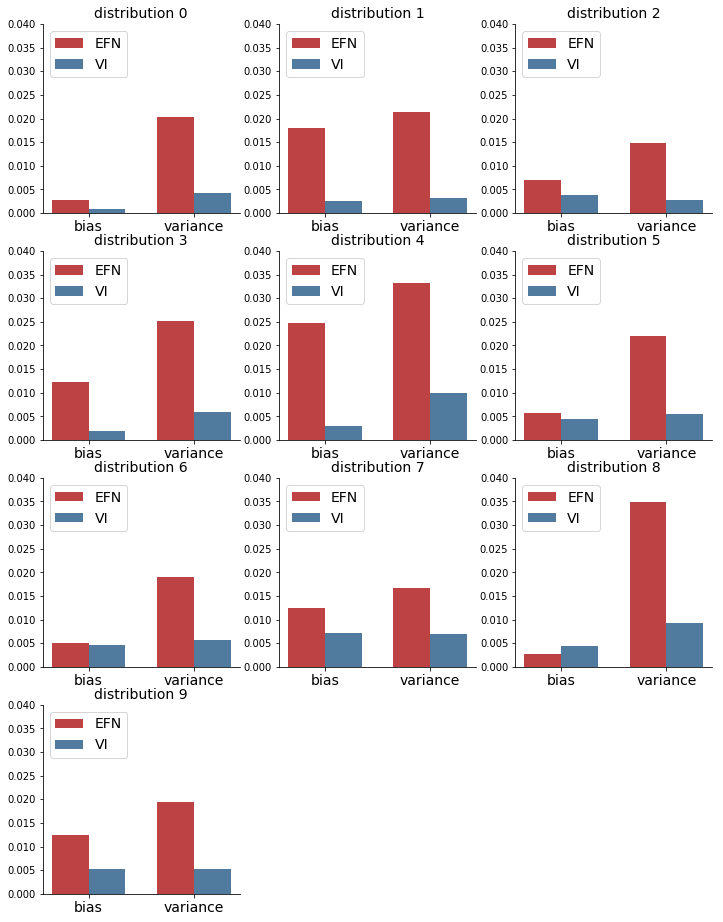

In [7]:
width = 0.35;
fontsize = 14;
ind = np.arange(2);
fig = plt.figure(figsize=(12,16));
for ds in range(num_ds):
    ax = plt.subplot(4,3,ds+1);
    rects1 = ax.bar(ind, np.array([EFN_biases_norm[ds], EFN_variances_norm[ds]]), width, color=palette[0]);
    rects2 = ax.bar(ind + width, np.array([VI_biases_norm[ds], VI_variances_norm[ds]]), width, color=palette[1])
    ax.legend(['EFN', 'VI'], loc=2, fontsize=fontsize);
    ax.set_ylabel('', fontsize=fontsize)
    ax.set_title('distribution %d' % ds, fontsize=fontsize)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(['bias', 'variance'], fontsize=fontsize);
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylim([0, 0.04])
plt.show();


643
735
775
552
695
547
659
579
661
685


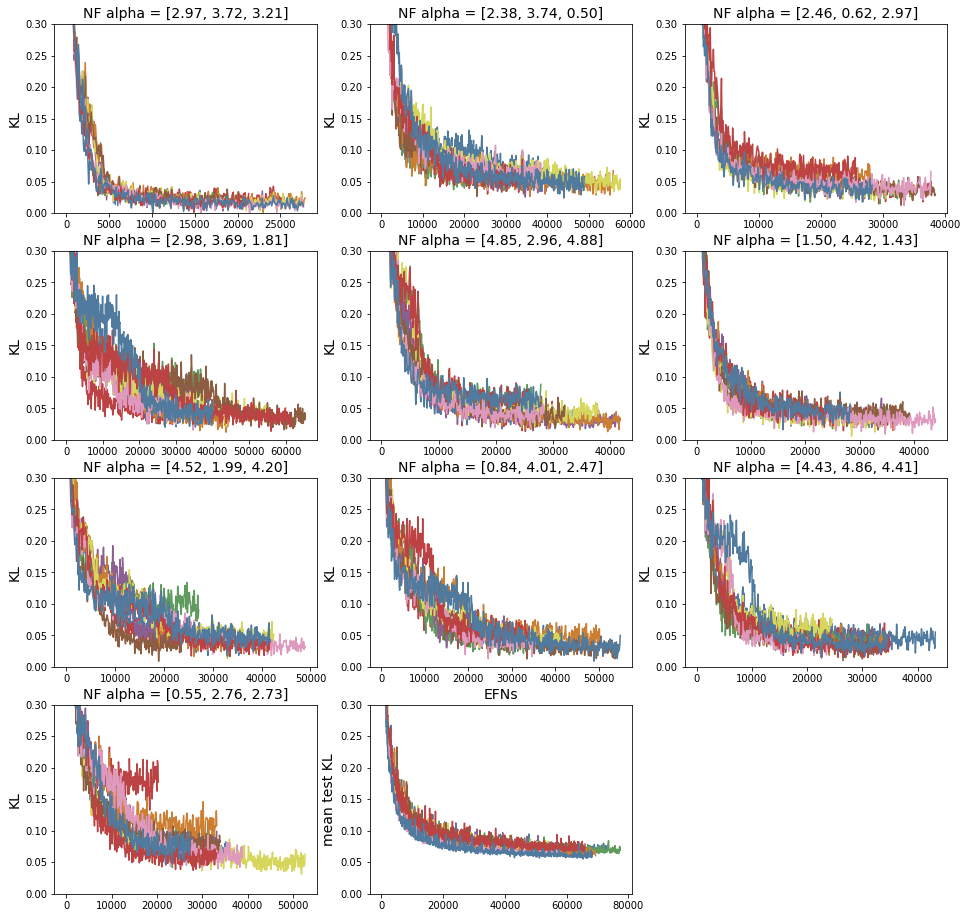

In [8]:
fontsize = 14;

num_iters = 2000;
plt.figure(figsize=(16,16));
for i in range(num_ds):
    ds = ds_list[i];
    plt.subplot(4,3,i+1);
    
    for j in range(num_rs):
        rs = rs_list[j];
        dist_info = {'dist_seed':ds};
        savedir = setup_IO(family, 'NF1', dir_str, '', K, M, flow_dict, {}, False, False, rs, dist_info);
        resdir = basedir + savedir;
        fname = resdir + 'results.npz';
        try:
            npzfile = np.load(fname);
            KLs = npzfile['test_KLs'];
        except:
            continue;
        check_rate = npzfile['check_rate'];
        final_it = int((npzfile['it']+1)/check_rate);
        its = np.arange(0, check_rate*final_it, check_rate);
        plt.plot(its, KLs[:final_it]);
        plt.ylabel('KL', fontsize=fontsize)
        plt.ylim([0,.3]);
        plt.title('NF alpha = [%.2f, %.2f, %.2f]' % (alpha_targs[i,0], alpha_targs[i,1], alpha_targs[i,2]), fontsize=fontsize);
        
K= 100;
M = 1000;
param_net_hps = {'L':4};
param_net_input_type = 'eta';
stochastic_eta = True;
give_hint = False;      
plt.subplot(4,3,num_ds+1);
for j in range(num_rs):
    rs = rs_list[j];
    savedir = setup_IO(family, 'EFN', dir_str, param_net_input_type, K, M, flow_dict,\
                   param_net_hps, stochastic_eta, give_hint, rs);
    resdir = basedir + savedir;
    fname = resdir + 'results.npz';
    try:
        npzfile = np.load(fname);
        KLs = npzfile['test_KLs'];
    except:
        continue;
    
    check_rate = npzfile['check_rate'];
    final_it = int((npzfile['it']+1)/check_rate);
    print(final_it);
    its = np.arange(0, check_rate*final_it, check_rate);
    plt.plot(its, np.mean(KLs[:final_it],1));
    plt.ylim([0,.3]);
    plt.ylabel('mean test KL', fontsize=fontsize)
    plt.title('EFNs', fontsize=fontsize);
        
plt.show();